# Initial look at zillow data set

In [728]:
import pandas as pd
import numpy as np
import sklearn as sk
import pickle
import xgboost

from sklearn import linear_model
from sklearn.preprocessing import Imputer, LabelEncoder
from sklearn.metrics import explained_variance_score, mean_absolute_error
import matplotlib.pyplot as plt

%matplotlib inline

In [729]:
df_properties_2016 = pd.read_csv('../data/properties_2016.csv')

In [730]:
df_properties_2017 = pd.read_csv('../data/properties_2017.csv')

In [731]:
df_properties = df_properties_2017

In [732]:
df_transactions_2016 = pd.read_csv('../data/train_2016.csv', parse_dates=['transactiondate'])
df_transactions_2017 = pd.read_csv('../data/train_2017.csv', parse_dates=['transactiondate'])

In [733]:
df_transactions = pd.concat((df_transactions_2016, df_transactions_2017), axis = 0)
# df_transactions = df_transactions_2016

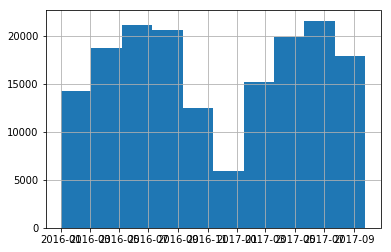

In [734]:
df_transactions.transactiondate.hist()

### check duplicates for each parcelID

In [735]:
df_properties.parcelid.unique().shape[0] == df_properties.parcelid.shape[0]

True

In [736]:
# put just treat houses that are sold multiple times as different hosues for simplication purpose
(df_transactions.parcelid.value_counts() > 1).sum() * 1.0 / df_transactions.shape[0]

0.015897503097302965

### merge data

In [737]:
df = pd.merge(left=df_properties, right=df_transactions, on='parcelid')
df_pred = pd.merge(left=df_properties, right=df_transactions.drop_duplicates(subset='parcelid',keep='first'), on='parcelid', how='left')

### Pre-processing of some fields (remove outliers)

In [738]:
df.shape

(167888, 60)

### feature engineering

### Define features

In [739]:
all_fields = set(df.columns)

# these are fields that are used to identify fields
identifiers = set(['transactiondate', 'parcelid'])

# log error that we want to model
label = set(['logerror'])

# the following are categorical features
feats_objects = set(df.columns[df.dtypes==object])
#  ['taxdelinquencyflag',
#  'propertycountylandusecode',
#  'propertyzoningdesc',
#  'fireplaceflag',
#  'hashottuborspa']

# the following are numerical features that should be treated as categorical features
feats_numeric_to_categorical = set([
    'airconditioningtypeid',
    'architecturalstyletypeid',
    'buildingqualitytypeid',
    'buildingclasstypeid',
    'decktypeid',
    'fips',
    'heatingorsystemtypeid',
    'propertylandusetypeid',
    'regionidcounty',
    'regionidcity',
    'regionidzip',
    'regionidneighborhood',
    'storytypeid',
    'typeconstructiontypeid',
    'yearbuilt',
    'assessmentyear',
    'taxdelinquencyyear'
])


# the rest are numeric features
feats_numeric = set([
    'basementsqft',
    'bathroomcnt',
    'bedroomcnt',
    'calculatedbathnbr',
    'threequarterbathnbr',
    'finishedfloor1squarefeet',
    'calculatedfinishedsquarefeet',
    'finishedsquarefeet6',
    'finishedsquarefeet12',
    'finishedsquarefeet13',
    'finishedsquarefeet15',
    'finishedsquarefeet50',
    'fireplacecnt',
    'fullbathcnt',
    'garagecarcnt',
    'garagetotalsqft',
    'hashottuborspa',
    'lotsizesquarefeet',
    'numberofstories',
    'poolcnt',
    'poolsizesum',
    'pooltypeid10',
    'pooltypeid2',
    'pooltypeid7',
    'roomcnt',
    'unitcnt',
    'yardbuildingsqft17',
    'yardbuildingsqft26',
    'taxvaluedollarcnt',
    'structuretaxvaluedollarcnt',
    'landtaxvaluedollarcnt',
    'taxamount'
])

# fields that are thrown away for now
feats_for_consideration_later = set([
    'latitude',
    'longitude',
    'rawcensustractandblock',
    'censustractandblock',
])

In [740]:
feats_categorical = feats_numeric_to_categorical | feats_objects
feats_numeric = feats_numeric
feats = feats_categorical | feats_numeric

feats_categorical = list(feats_categorical)
feats_numeric = list(feats_numeric)
feats = list(feats)

### convert categorical features

In [741]:
# need to impute all these with a `missing` value first
df[feats_categorical] = df[feats_categorical].fillna('--unknown--')
df_pred[feats_categorical] = df_pred[feats_categorical].fillna('--unknown--')

In [742]:
# use label encoder to encode all categorical variables
le = LabelEncoder()
for feat in feats_categorical:
    df_pred[[feat]] = df_pred[[feat]].apply(le.fit_transform)
    df[[feat]] = df[[feat]].apply(le.transform)

### impute missing values for numeric values

In [743]:
imp =  Imputer(missing_values=np.nan,strategy="median",axis=0)

df_pred[feats_numeric] = imp.fit_transform(df_pred[feats_numeric])
df[feats_numeric] = imp.transform(df[feats_numeric])

### split train-test

In [744]:
mask_train = df.transactiondate < '2017-06-01'
# mask_test_oct = (df.transactiondate >= '2016-10-01') & (df.transactiondate < '2016-11-01')
# mask_test_nov = (df.transactiondate >= '2016-11-01') & (df.transactiondate < '2016-12-01')
# mask_test_dec = (df.transactiondate >= '2016-12-01') & (df.transactiondate < '2017-01-01')
# mask_test = mask_test_oct | mask_test_nov | mask_test_dec
mask_test = (df.transactiondate >= '2017-06-01')

In [745]:
X_train = df.loc[mask_train, feats].astype(float).values
X_test = df.loc[mask_test, feats].astype(float).values

y_train = np.array(df.loc[mask_train, 'logerror'].tolist())
y_test = np.array(df.loc[mask_test, 'logerror'].tolist())

data = (X_train, X_test, y_train, y_test)

In [746]:
# save data
pickle.dump(data, open('../tmp/training_and_testing_data_2017.pkl', 'w'))

### train a XGboost regressor

In [747]:
xgb = xgboost.XGBRegressor(n_estimators=200, 
                           #colsample_bytree=1, 
                           max_depth=3, 
                           #reg_alpha=0.001,
                           objective='reg:linear'
                          )

In [748]:
xgb.fit(X_train, y_train)

XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1, gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=200, nthread=-1,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

In [749]:
y_pred = xgb.predict(X_test)

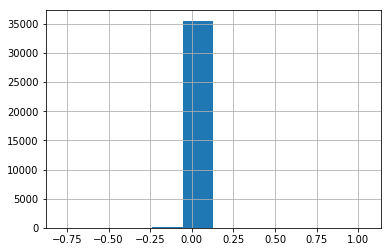

In [750]:
pd.Series(y_pred).hist()

In [751]:
explained_variance_score(y_pred=y_pred, y_true=y_test)

0.0001891568778926711

In [752]:
mean_absolute_error(y_pred=y_pred, y_true=y_test)

0.069960510979235044

### generate final model

In [753]:
xgb.fit(np.concatenate((X_train, X_test), axis=0),np.concatenate((y_train, y_test), axis = 0))

XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1, gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=200, nthread=-1,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

## Generate submission file

In [754]:
# imputed missing values previously

In [755]:
y_pred = xgb.predict((df_pred[feats].values))

In [756]:
# assume all 6 months have the same prediction results.

In [757]:
df_submission = df_pred[['parcelid','logerror']]

In [758]:
df_submission['pred'] = y_pred

/Users/dai_li/Workspace/VirtualEnv/competition/lib/python2.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [759]:
# coalesce actual log error with prediction results

df_submission['201610'] = df_submission['logerror'].combine_first(df_submission['pred'])
df_submission['201611'] = df_submission['logerror'].combine_first(df_submission['pred'])
df_submission['201612'] = df_submission['logerror'].combine_first(df_submission['pred'])

df_submission['201710'] = df_submission['logerror'].combine_first(df_submission['pred'])
df_submission['201711'] = df_submission['logerror'].combine_first(df_submission['pred'])
df_submission['201712'] = df_submission['logerror'].combine_first(df_submission['pred'])

/Users/dai_li/Workspace/VirtualEnv/competition/lib/python2.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/dai_li/Workspace/VirtualEnv/competition/lib/python2.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/Users/dai_li/Workspace/VirtualEnv/competition/lib/python2.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is 

In [760]:
del df_submission['logerror']
del df_submission['pred']

In [761]:
df_submission.shape[0] == 2985217

True

In [762]:
df_submission.to_csv('../data/submission_20171003_2017.csv', header=True, index=False)

### train a simple elastic net model

In [366]:
alphas = np.logspace(-5, 1, 5)
enet = linear_model.ElasticNet(l1_ratio=0.7)
train_errors = list()
test_errors = list()
for alpha in alphas:
    print 'fitting enet with alpha={} ..'.format(alpha)
    enet.set_params(alpha=alpha)
    enet.fit(X_train, y_train)
    train_errors.append(enet.score(X_train, y_train))
    test_errors.append(enet.score(X_test, y_test))
    

i_alpha_optim = np.argmax(test_errors)
alpha_optim = alphas[i_alpha_optim]
print("Optimal regularization parameter : %s" % alpha_optim)


fitting enet with alpha=1e-05 ..
fitting enet with alpha=0.000316227766017 ..
fitting enet with alpha=0.01 ..
fitting enet with alpha=0.316227766017 ..
fitting enet with alpha=10.0 ..
Optimal regularization parameter : 1e-05


In [367]:
test_errors

[0.99999971615990368,
 0.9997181713348946,
 0.77204439825672799,
 -0.90334030227054807,
 -0.55500696840416941]

In [368]:
# Estimate the coef_ on full data with optimal regularization parameter
enet.set_params(alpha=alpha_optim)
coef_ = enet.fit( np.concatenate((X_train, X_test), axis=0),np.concatenate((y_train, y_test), axis = 0)).coef_

In [369]:
coef_

array([  0.00000000e+00,  -0.00000000e+00,   9.99635530e-01,
         1.79867474e-12,   8.41575466e-10,  -1.05098144e-10,
        -0.00000000e+00,   0.00000000e+00,  -0.00000000e+00,
         0.00000000e+00,   1.51867387e-09,   0.00000000e+00,
         0.00000000e+00,  -3.04123232e-11,   0.00000000e+00,
        -0.00000000e+00,  -0.00000000e+00,   1.63324011e-19,
         0.00000000e+00,   1.03769633e-09,  -0.00000000e+00,
        -1.95805717e-12,  -0.00000000e+00,  -0.00000000e+00,
        -4.93848069e-09,   1.41314952e-09,  -4.38624639e-10,
        -0.00000000e+00,  -0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,  -2.71582503e-12,
         0.00000000e+00,   0.00000000e+00,  -0.00000000e+00,
        -0.00000000e+00,  -0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   5.51807173e-12,  -0.00000000e+00,
        -3.23768042e-09,   2.25359881e-12,  -2.72425603e-11,
         2.91836845e-11,   3.84585246e-09,   0.00000000e+00,
        -0.00000000e+00,

### visualize

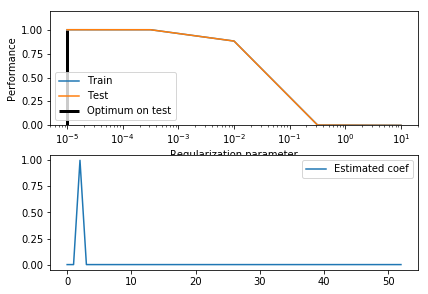

In [257]:
import matplotlib.pyplot as plt
plt.subplot(2, 1, 1)
plt.semilogx(alphas, train_errors, label='Train')
plt.semilogx(alphas, test_errors, label='Test')
plt.vlines(alpha_optim, plt.ylim()[0], np.max(test_errors), color='k',
           linewidth=3, label='Optimum on test')
plt.legend(loc='lower left')
plt.ylim([0, 1.2])
plt.xlabel('Regularization parameter')
plt.ylabel('Performance')

# Show estimated coef_ vs true coef
plt.subplot(2, 1, 2)
plt.plot(coef_, label='Estimated coef')
plt.legend()
plt.subplots_adjust(0.09, 0.04, 0.94, 0.94, 0.26, 0.26)
plt.show()

### generate prediction results for submission

In [86]:
df_submission_sample = pd.read_csv('../data/sample_submission.csv')

In [370]:
df_submission_sample.head()

,ParcelId,201610,201611,201612,201710,201711,201712
0,10754147,0,0,0,0,0,0
1,10759547,0,0,0,0,0,0
2,10843547,0,0,0,0,0,0
3,10859147,0,0,0,0,0,0
4,10879947,0,0,0,0,0,0


In [371]:
df_pred = df_properties.loc[:, feat]

In [372]:
# note I should not use oct-dec's test data to train the final model. will fix later
# y_pred_oct = enet.predict(df.loc[mask_test_oct, feat].astype(float).values)
# y_pred_nov = enet.predict(df.loc[mask_test_nov, feat].astype(float).values)
# y_pred_dec = enet.predict(df.loc[mask_test_dec, feat].astype(float).values)
y_pred = enet.predict(imp.transform(df_pred.astype(float).values))

In [373]:
np.histogram(y_pred)

(array([      1,       3,       8,      65, 2985118,      14,       3,
              2,       2,       1]),
 array([ 0.00412694,  0.00453625,  0.00494556,  0.00535486,  0.00576417,
         0.00617347,  0.00658278,  0.00699208,  0.00740139,  0.00781069,
         0.00822   ]))

In [374]:
df_bk = df_pred

In [375]:
df_bk.loc[:, '201610'] = y_pred
df_bk.loc[:, '201611'] = y_pred
df_bk.loc[:, '201612'] = y_pred
df_bk.loc[:, '201710'] = y_pred
df_bk.loc[:, '201711'] = y_pred
df_bk.loc[:, '201712'] = y_pred

In [380]:
df_bk = df_bk[['201610','201611','201612','201710','201711','201712']]

In [381]:
df_submission = pd.concat((df_properties[['parcelid']], df_bk), axis = 1)

In [382]:
# del df_submission['parcelid']
df_submission.fillna(0, inplace=True)

In [277]:
# df_submission = pd.merge(
#     left=df_submission_sample[['ParcelId']],
#     right=df_bk,
#     left_on ='ParcelId',
#     right_on='parcelid',
#     how = 'left'
# )

In [383]:
df_submission.head()

,parcelid,201610,201611,201612,201710,201711,201712
0,10754147,0.005899,0.005899,0.005899,0.005899,0.005899,0.005899
1,10759547,0.005899,0.005899,0.005899,0.005899,0.005899,0.005899
2,10843547,0.005972,0.005972,0.005972,0.005972,0.005972,0.005972
3,10859147,0.005904,0.005904,0.005904,0.005904,0.005904,0.005904
4,10879947,0.005904,0.005904,0.005904,0.005904,0.005904,0.005904


In [384]:
df_submission.shape[0] == 2985217

True

In [385]:
df_submission.to_csv('../data/submission.csv', header=True, index=False)

## submission requirements:
1. have header
2. no row index
3. Evaluation Exception: Submission must be 2985217 rows
4. fill NAs with 0

### random search

In [ ]:
MODEL = {"enet": sklearn.linear_model.ElasticNet(random_state=42),
         }

# tune the hyperparameters via a randomized search
# params for xgb
elastic_net_params = {
    "max_depth": range(5, 26, 5),
}


# initialize params dict
PARAMS = {
    'xgb': xgb_params,
    'rfc': rfc_params,
    'gbc': gbc_params
}

# define cost function
pr_auc_scorer = make_scorer(average_precision_score)

# define num iters
N_ITER = {
    'enet': 1,
}